In [1]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
from web3 import Web3, HTTPProvider
import matplotlib.pyplot as plt


@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo



In [2]:
def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


In [3]:
markets = get_markets_map()
markets

{'sfrxETH': MarketInfo(address='0xEC0820EfafC41D8943EE8dE495fC9Ba8495B15cf', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0xfA96ad0a9E64261dB86950e2dA362f5572c5c6fd', rate=0.1490383755278708, total_debt=5885985.377473533, n_loans=16, debt_ceiling=50000000.00000001, borrowable=44114014.622526474, pending_fees=3505.3504619250866, collected_fees=1681459.105713004, collateral_amount=3048.286889870768, collateral_amount_usd=11432213.74982807, stablecoin_amount=0.0, collateral_token=TokenInfo(symbol='sfrxETH', address='0xac3E018457B222d93114458476f3E3416Abbe38F'), stablecoin_token=TokenInfo(symbol='crvUSD', address='0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E')),
 'wstETH': MarketInfo(address='0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0x37417B2238AA52D0DD2D6252d989E728e8f706e4', rate=0.14652727171433289, total_debt=4564361.514904806, n_loans=90, debt_ceiling=150000000.0, borrowable=145435638.4850

In [4]:
from datetime import datetime, timedelta, timezone

def fetch_curve_markets_collateral_under_sl(controller: str, 
                                            chain: str = "ethereum", 
                                            start: datetime = datetime.now() - timedelta(days=180), 
                                            end: datetime = datetime.now()) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/liquidations/{chain}/{controller}/soft_liquidation_ratio"
    params = {
        "start": int(start.timestamp()),
        "end": int(end.timestamp()),
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    output = response.json()

    return output["data"]

def score_with_limits(score_this: float,
                      upper_limit: float,
                      lower_limit: float,
                      direction: bool,
                      mid_limit: float = None) -> float:
    """
    Score the market based on the collateral ratio comparison

    Args:
        score_this (float): Value to be scored
        upper_limit (float): Upper boundary for scoring
        lower_limit (float): Lower boundary for scoring
        mid_limit (float): Middle point representing 0.5 score
        direction (bool): If True, higher values get higher scores
                        If False, lower values get higher scores

    Returns:
        float: Score between 0 and 1
    """

    if mid_limit is None:
        mid_limit = (upper_limit + lower_limit) / 2

    if direction:
        if score_this >= upper_limit:
            return 1.0
        elif score_this <= lower_limit:
            return 0.0
        else:
            # Score between lower and mid
            if score_this <= mid_limit:
                return 0.5 * (score_this - lower_limit) / (mid_limit - lower_limit)
            # Score between mid and upper
            else:
                return 0.5 + 0.5 * (score_this - mid_limit) / (upper_limit - mid_limit)
    else:
        if score_this >= upper_limit:
            return 0.0
        elif score_this <= lower_limit:
            return 1.0
        else:
            # Score between lower and mid
            if score_this <= mid_limit:
                return 1.0 - 0.5 * (score_this - lower_limit) / (mid_limit - lower_limit)
            # Score between mid and upper
            else:
                return 0.5 - 0.5 * (score_this - mid_limit) / (upper_limit - mid_limit)

    # Ensure score is between 0 and 1
    return max(0.0, min(1.0, score))



In [5]:
print("\nCOLLATERAL UNDER SOFT LIQUIDATION SCORING OVERVIEW")
print("=" * 95)
print(f"{'Market':8} | {'Current %':>10} | {'7d Avg':>10} | {'30d Avg':>10} | {'7d/30d':>10} | {'Abs Score':>10} | {'Rel Score':>10} | {'Final':>8}")
print("-" * 95)

for market, info in markets.items():
    data = fetch_curve_markets_collateral_under_sl(info.address)
    sl_df = pd.DataFrame(data)
    sl_df = sl_df.sort_values("timestamp")
    sl_df["timestamp"] = pd.to_datetime(sl_df["timestamp"], format="%Y-%m-%dT%H:%M:%S")
    sl_df["debt_under_sl_ratio_7d"] = sl_df["debt_under_sl_ratio"].rolling(7).mean()
    sl_df["debt_under_sl_ratio_30d"] = sl_df["debt_under_sl_ratio"].rolling(30).mean()
    sl_df["collateral_under_sl_ratio_7d"] = sl_df["collateral_under_sl_ratio"].rolling(7).mean()
    sl_df["collateral_under_sl_ratio_30d"] = sl_df["collateral_under_sl_ratio"].rolling(30).mean()
    sl_df.set_index("timestamp", inplace=True)
    

    latest_row = sl_df.iloc[-1].to_dict()
    current = latest_row["collateral_under_sl_ratio"]
    avg_7d = latest_row["collateral_under_sl_ratio_7d"]
    avg_30d = latest_row["collateral_under_sl_ratio_30d"]
    
    # Handle division by zero case
    ratio_7d_30d = 1.0 if avg_30d == 0 else avg_7d / avg_30d
    
    abs_score = score_with_limits(current, 0.8, 0, False)
    rel_score = score_with_limits(ratio_7d_30d, 2.5, 0.5, False, 1)
    final_score = 0.4 * abs_score + 0.6 * rel_score
    
    # Format numbers for better readability
    current_fmt = f"{current*100:.2f}%"
    avg_7d_fmt = f"{avg_7d*100:.2f}%"
    avg_30d_fmt = f"{avg_30d*100:.2f}%"
    ratio_fmt = f"{ratio_7d_30d:.2f}"
    
    print(f"{market:8} | {current_fmt:>10} | {avg_7d_fmt:>10} | {avg_30d_fmt:>10} | {ratio_fmt:>10} | {abs_score*100:>9.2f}% | {rel_score*100:>9.2f}% | {final_score*100:>7.2f}%")

print("=" * 95)


COLLATERAL UNDER SOFT LIQUIDATION SCORING OVERVIEW
Market   |  Current % |     7d Avg |    30d Avg |     7d/30d |  Abs Score |  Rel Score |    Final
-----------------------------------------------------------------------------------------------
sfrxETH  |      0.00% |      0.00% |      0.00% |       1.00 |    100.00% |     50.00% |   70.00%
wstETH   |      0.00% |      0.00% |     27.50% |       0.00 |    100.00% |    100.00% |  100.00%
WBTC     |      7.72% |      9.66% |     11.47% |       0.84 |     90.35% |     65.79% |   75.61%
WETH     |      1.53% |      5.25% |      7.48% |       0.70 |     98.09% |     79.79% |   87.11%
tBTC     |      0.00% |      0.00% |      0.00% |       1.00 |    100.00% |     50.00% |   70.00%


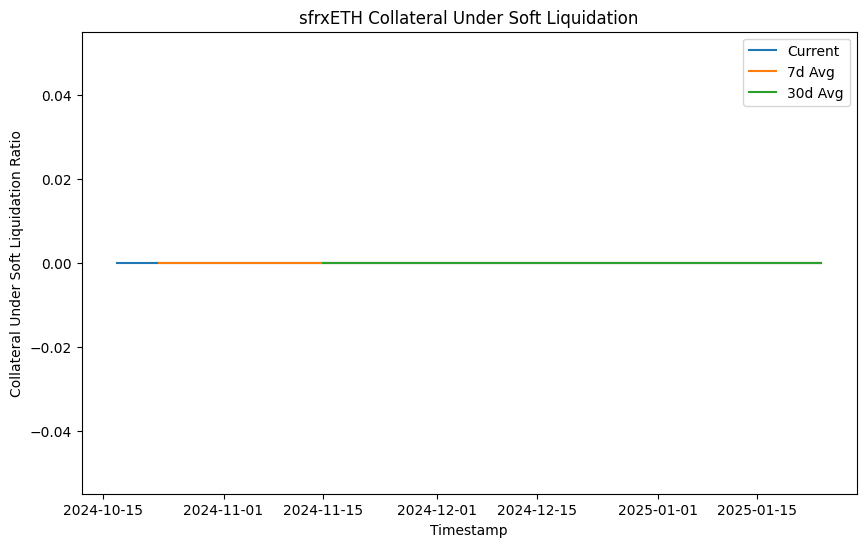

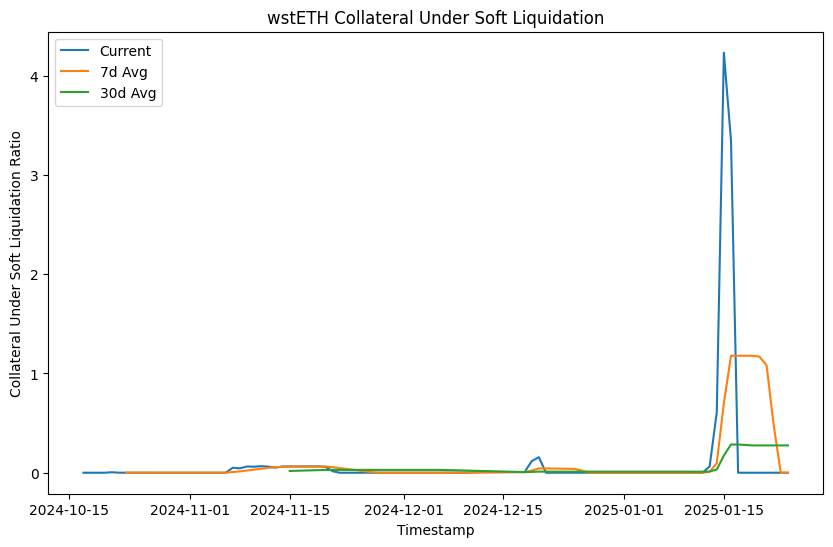

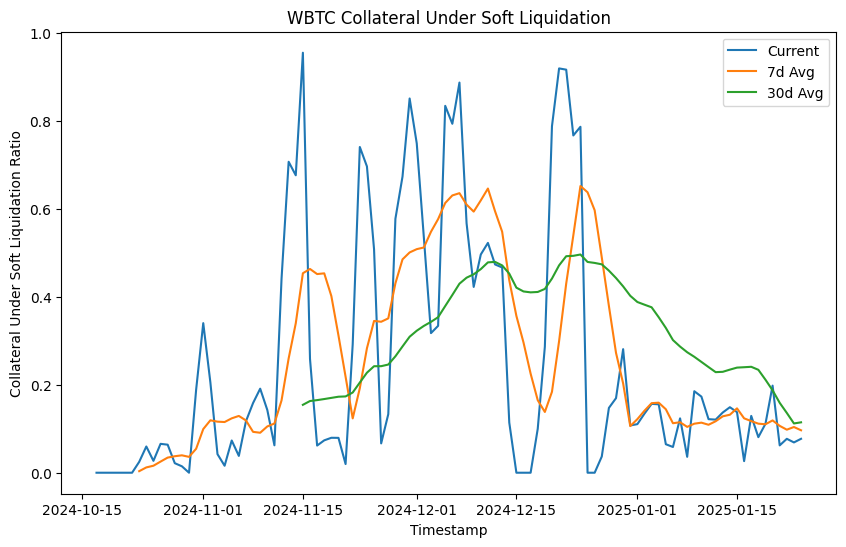

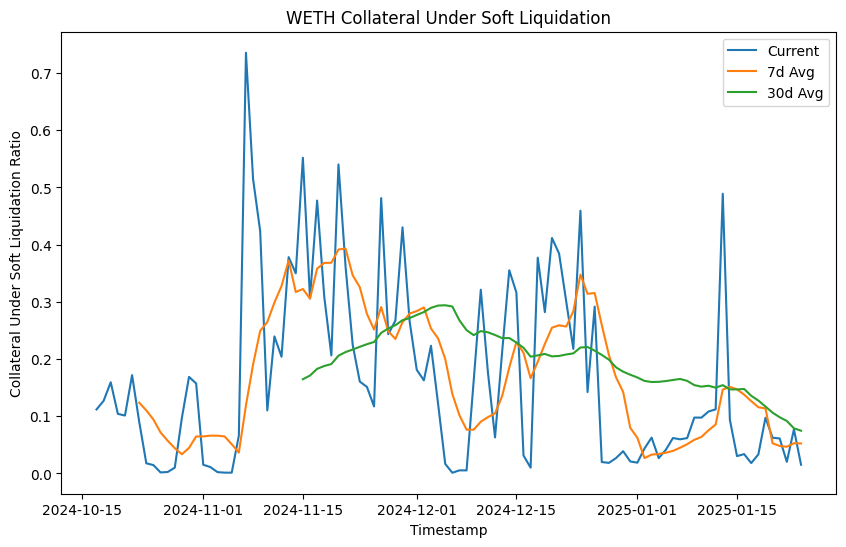

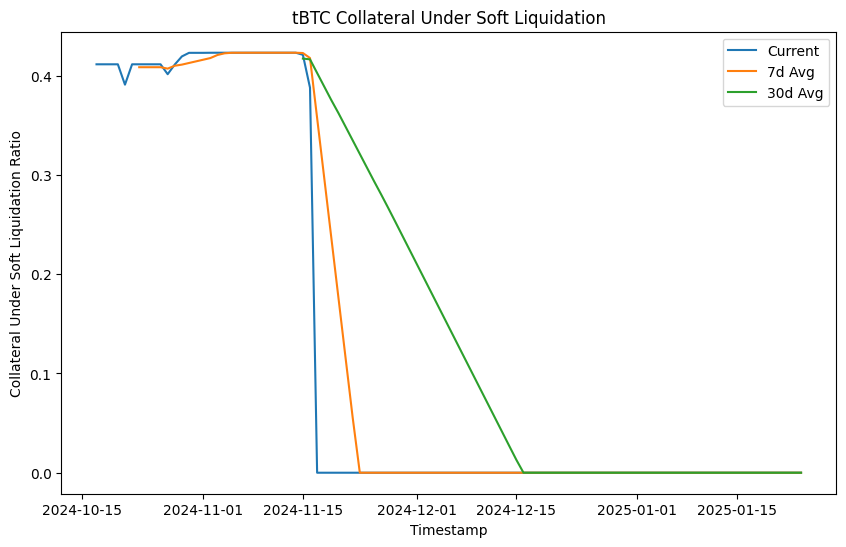

In [6]:
for market, info in markets.items():
    data = fetch_curve_markets_collateral_under_sl(info.address)
    sl_df = pd.DataFrame(data)
    sl_df = sl_df.sort_values("timestamp")
    sl_df["timestamp"] = pd.to_datetime(sl_df["timestamp"], format="%Y-%m-%dT%H:%M:%S")
    sl_df["debt_under_sl_ratio_7d"] = sl_df["debt_under_sl_ratio"].rolling(7).mean()
    sl_df["debt_under_sl_ratio_30d"] = sl_df["debt_under_sl_ratio"].rolling(30).mean()
    sl_df["collateral_under_sl_ratio_7d"] = sl_df["collateral_under_sl_ratio"].rolling(7).mean()
    sl_df["collateral_under_sl_ratio_30d"] = sl_df["collateral_under_sl_ratio"].rolling(30).mean()
    sl_df.set_index("timestamp", inplace=True)
    
    # Plot sl_df["collateral_under_sl_ratio"], sl_df["collateral_under_sl_ratio_7d"], sl_df["collateral_under_sl_ratio_30d"]
    plt.figure(figsize=(10, 6))
    plt.plot(sl_df["collateral_under_sl_ratio"], label="Current")
    plt.plot(sl_df["collateral_under_sl_ratio_7d"], label="7d Avg")
    plt.plot(sl_df["collateral_under_sl_ratio_30d"], label="30d Avg")
    plt.title(f"{market} Collateral Under Soft Liquidation")
    plt.xlabel("Timestamp")
    plt.ylabel("Collateral Under Soft Liquidation Ratio")
    plt.legend()
    plt.show()